<div style="background-color: #a7d9b6; color: black; padding: 20px">
  <h1 style="text-align: center"><strong>TPE Yann Inas 2023</strong></h1>
  <h2 style="text-align: center"><em>Détection de fraude bancaire</em></h2>
</div>

<!-- Pour le mode sombre -->

<style>
@media (prefers-color-scheme: dark) {
  div {
    background-color: #303030;
    color: white;
  }
}
</style>


Maintenant qu'on a réduit la dimension sur les marques, et qu'on a seulement 30 colonnes, on peut alors y inclure quelques catégories. On va alors faire les mêmes études que pour les marques.

# 1. Imports

In [43]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb

In [44]:
DATA_x = pd.read_csv('data/X_train_G3tdtEn.csv', delimiter = ',',encoding = 'latin1', low_memory=False)
DATA_y = pd.read_csv('data/Y_train_2_XPXJDyy.csv', delimiter = ',',encoding = 'latin1', low_memory=False)

# 2. Statistiques

In [45]:
categ = []
nb_colonnes = 4 #item1-2-3-4

for i in range(1, nb_colonnes+1):
    categ.append(DATA_x['item'+str(i)].astype(str).unique())

tableau_des_categ = np.unique(np.concatenate(categ))
# =========================================================================
df_categ = pd.DataFrame(columns=tableau_des_categ, index=DATA_x.index)
df_categ['ID'] = DATA_x['ID']

for row in DATA_x.index:
    for i in range(1, nb_colonnes+1):
        categorie = DATA_x[f'item{i}'][row]
        nb_items = DATA_x[f"Nbr_of_prod_purchas{i}"][row]

        if type(categorie) == float: # Stop si valeur nulle
            break
    
        categ_column = f"{categorie}"
        if categ_column in df_categ.columns:
            df_categ[categ_column][row] = nb_items

df_categ = df_categ.fillna(0)
df_categ.head()

C:\Users\kille\AppData\Local\Temp\ipykernel_20584\3576277426.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categ[categ_column][row] = nb_items


,6 SPACE GREY 32GB,AERIALS REMOTE CONTROLS,APPLE PRODUCTDESCRIPTION,APPLE S,AUDIO ACCESSORIES,BABY & CHILD TRAVEL,BABY CHANGING,BABY CHILD TRAVEL,BABY FEEDING,BABY PLAY EQUIPMENT,...,WINDOW DRESSING,WOMEN S ACCESSORIES,WOMEN S CLOTHES,WOMEN S FOOTWEAR,WOMEN S NIGHTWEAR,WOMENS ACCESSORIES,WOMENS CLOTHES,WOMENS FOOTWEAR,nan,ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,85517
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,51113
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,83008
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,78712
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,77846


In [71]:
df_categ.to_csv("data/df_categ_save.csv", sep = ',',encoding = 'latin1')

In [47]:
# Calculer le nombre total d'achats pour chaque colonne
achats_par_colonne = df_categ.sum()

# Filtrer les colonnes qui ont plus de x achats
x_achats = 10
colonnes_plus_de_x_achats = achats_par_colonne[achats_par_colonne > x_achats].index

# Sélectionner uniquement les colonnes qui ont plus de 10 achats
df_plus_de_x_achats = df_categ[colonnes_plus_de_x_achats]
print("Nombre de categ qui ont plus de ", x_achats,"achats : ", df_plus_de_x_achats.shape[1]-1, "sur", df_categ.shape[1]-1, "categ de base")

Nombre de categ qui ont plus de  10 achats :  98 sur 161 categ de base


In [48]:
merged_plus_x_achats = pd.merge(df_plus_de_x_achats,DATA_y,on='ID')
merged_plus_x_achats_fraud = merged_plus_x_achats[merged_plus_x_achats['fraud_flag'] == 1]

<Axes: >

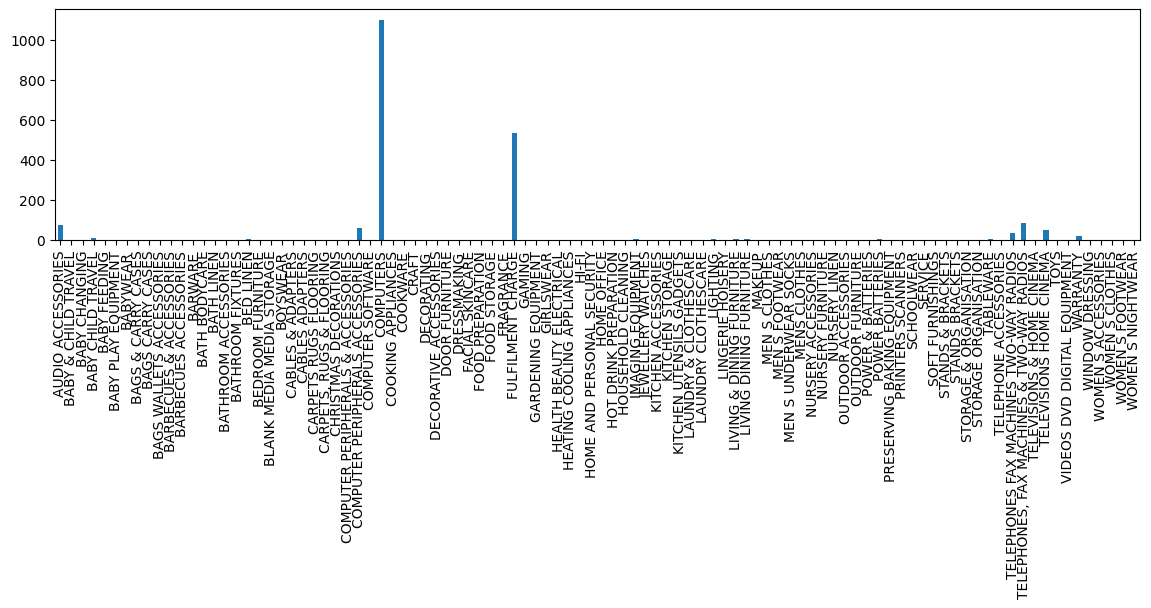

In [49]:
plt.figure(figsize=(14,3))
merged_plus_x_achats_fraud.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum().plot(kind='bar')

<Axes: >

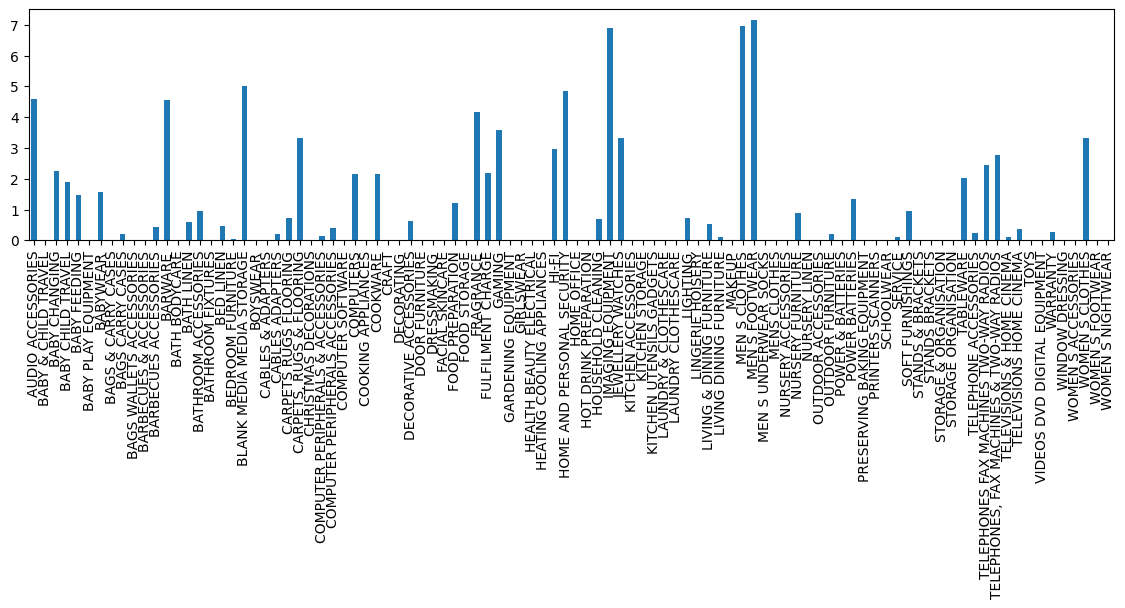

In [50]:
tab1 = merged_plus_x_achats_fraud.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab2 = merged_plus_x_achats.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab3 = 100 * tab1 / (tab1 + tab2)
plt.figure(figsize=(14,3))
tab3.plot(kind='bar')

In [65]:
categ_frauduleuses_pourcentage = tab3[tab3 > 1].index
print("Nombre de categ qui vendent plus de 10items et qui ont un pourcentage de fraude supérieur à 1% :", len(categ_frauduleuses_pourcentage) )

Nombre de categ qui vendent plus de 10items et qui ont un pourcentage de fraude supérieur à 0.1% : 20


In [66]:
les_fraudes = merged_plus_x_achats[categ_frauduleuses_pourcentage]

les_fraudes['Nb_of_items'] = DATA_x['Nb_of_items']

cash_price_columns = ["cash_price" + str(i) for i in range(1, 5)]
X_cash_price = DATA_x[cash_price_columns]
les_fraudes = pd.concat([les_fraudes, X_cash_price], axis=1)
les_fraudes = les_fraudes.fillna(0)

les_fraudes.head()

C:\Users\kille\AppData\Local\Temp\ipykernel_20584\629311957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  les_fraudes['Nb_of_items'] = DATA_x['Nb_of_items']


,AUDIO ACCESSORIES,BABY CHANGING,BARWARE,BLANK MEDIA MEDIA STORAGE,"CARPETS, RUGS & FLOORING",COMPUTERS,COOKWARE,FRAGRANCE,FULFILMENT CHARGE,GAMING,...,MEN S FOOTWEAR,TABLEWARE,TELEPHONES FAX MACHINES TWO-WAY RADIOS,"TELEPHONES, FAX MACHINES & TWO-WAY RADIOS",WOMEN S CLOTHES,Nb_of_items,cash_price1,cash_price2,cash_price3,cash_price4
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,889.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,409.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1399.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,689.0,119.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1199.0,0.0,0.0,0.0


# 3. Test de modèles

In [67]:
avg_preci = []
confusion = []
for i in range(30):
    X_train, X_test, Y_train, Y_test = train_test_split(les_fraudes, DATA_y, test_size = 0.2)
    Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
    Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)
    boost2 = xgb.XGBClassifier()
    boost2.fit(X_train, Y_train)
    y_pred2 = boost2.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred2).ravel()
    avg_preci.append(average_precision_score(Y_test, y_pred2))
    confusion.append((tn, fp, fn, tp))

In [68]:
print("Moyenne des average precision :", sum(avg_preci)/len(avg_preci))

Moyenne des average precision : 0.04818581251268363


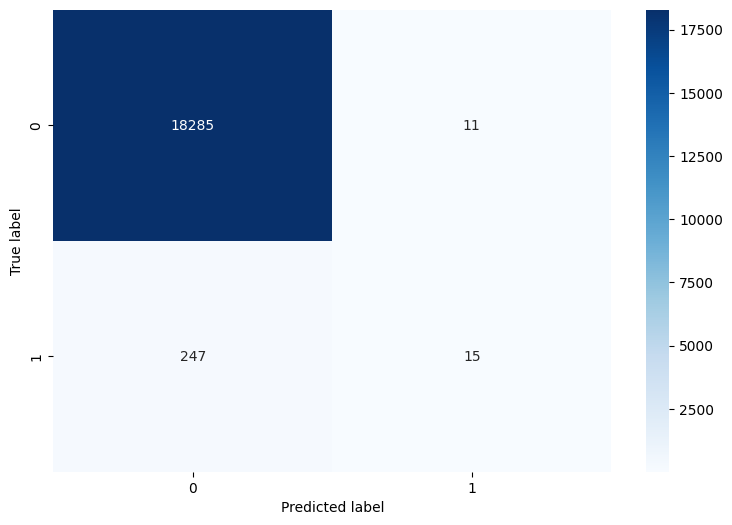

In [69]:
# Calculer la moyenne de chaque élément de la matrice de confusion
avg_confusion = np.mean(confusion, axis=0)

# Créer une matrice de confusion en utilisant la moyenne
confusion_array = np.array([[avg_confusion[0], avg_confusion[1]], [avg_confusion[2], avg_confusion[3]]])

# Créer une heatmap à partir de la matrice de confusion
plt.figure(figsize=(9,6))
sns.heatmap(confusion_array, annot=True, cmap='Blues', fmt=".0f")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [70]:
print("Y_train goods : ", Y_train[Y_train['fraud_flag'] == 0].shape)
print("Y_train bad : ", Y_train[Y_train['fraud_flag'] == 1].shape)
print("Y_test goods : ", Y_test[Y_test['fraud_flag'] == 0].shape)
print("Y_test bad : ", Y_test[Y_test['fraud_flag'] == 1].shape)

Y_train goods :  (73184, 1)
Y_train bad :  (1048, 1)
Y_test goods :  (18287, 1)
Y_test bad :  (271, 1)


Le meilleur résultat : selectionner les catégories à + de 10 achats et à + de 1% de fraudes